# Explore the data

## Import libraries

In [83]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import regex as re

## Load the data

In [7]:
with open('product_categories.txt', 'r') as categories_fh:
    categories = [category.strip() for category in categories_fh.readlines()]
    
with open('product_data.json', 'r') as data_fh:
    data = pd.DataFrame(json.load(data_fh))

print(f"Number of categories = {len(categories)}")
print()
for category in categories:
    print(category)
    
print()    
print(f"Number of products = {len(data)}")

small_sample = data.sample(10)
large_sample = data.sample(100)


display(small_sample)

Number of categories = 11

Dresses
Tops
Jeans
Skirts
Rompers
Shoes
Bags
Jewelry
Swimwear
Intimates
Others

Number of products = 1000


,description,images_url
332,\nDesigner Notes:\nThe Louisa Nightgown is a t...,http://cdn.shopify.com/s/files/1/0276/9941/pro...
468,Sperry has been making classic slip-free shoe ...,https://www.jcrew.com/s7-img-facade/F7316_EG41...
191,Shop the Women's Dreamy Cotton Pajama Set In S...,https://www.jcrew.com/s7-img-facade/B7341_KU65...
392,,https://www.hue.com/media/catalog/product/cach...
355,Shop the Women's Petite Long Tie-Waist Jacket ...,https://www.jcrew.com/s7-img-facade/J1706_BR11...
946,"<meta charset=""utf-8""><span>We like to imagine...",//cdn.shopify.com/s/files/1/1067/4288/products...
351,Shop the Women's Demi-Fine 14K Gold-Plated Dro...,https://www.jcrew.com/s7-img-facade/H4220_EC72...
566,"Everybody loves a flattering wrap top, so we m...",https://www.jcrew.com/s7-img-facade/J2842_KA28...
98,Shop the Contrast Ribbed Turtleneck at J.Cew a...,https://www.jcrew.com/s7-img-facade/H1838_NA64...
371,description,https://ao.ips.photos/aliceandolivia-java/imag...


## Explore text data

### How many descriptions have an exact word match with the category

In [8]:
def exact_match(desc):
    ret = []
    for category in categories:
        if category.lower() in desc.lower():
            ret.append(category)
    return ret

data['exact_match'] = data.description.apply(exact_match)
num_at_least_one_matches = data.exact_match.apply(lambda x: len(x) > 0).sum()

print(f"{num_at_least_one_matches} of the descriptions had an exact match with at least one of the categories.")

num_more_than_one = data.exact_match.apply(lambda x: len(x) > 1).sum()

print(f"{num_more_than_one} of the descriptions had an exact match with more than one of the categories.")

print()
print("The descriptions with more than one exact match are:")
print()
for desc in data[data.exact_match.apply(lambda x: len(x) > 1)].description:
    print(desc)
    print()

214 of the descriptions had an exact match with at least one of the categories.
2 of the descriptions had an exact match with more than one of the categories.

The descriptions with more than one exact match are:

In terms of hands-down closet essentials, our boy shirt ranks up there with blue jeans, chinos and little black dresses. Featuring a boyfriend-inspired fit that's tailored especially for you, this one sports a fun, confetti-inspired plaid we love. Body length: 27 1/4. Cotton/elastane. Machine wash. Import. Online only.

In terms of hands-down closet essentials, our boy shirt ranks up there with blue jeans, chinos and little black dresses. Featuring a boyfriend-inspired fit that's tailored especially for you, we made this one in a crisp cotton, with embroidered and embellished details we just love. Body length: 27 1/4. Cotton. Tab sleeves. Functional buttons at cuffs. Button placket. Hand wash. Import. Online only.



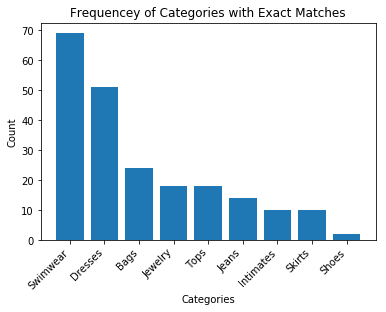

In [22]:
matches = Counter()
for match in data.exact_match:
    matches += Counter(match)
sorted_matches = matches.most_common()

plt.bar([key for key, val in sorted_matches], [val for key, val in sorted_matches])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Frequencey of Categories with Exact Matches')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print()

## Iterate with Regexes and data

For our baseline we can use the exact matches. It looks like we might be able to do a little better though. Maybe if we can find regex aliases for categories like "Footwear" for "Shoes" we might be able to get better results.

In [79]:
aliases = {
    'Dresses': [r'\bdress'],
    'Tops': [r'\btop', r'shirt', r'tank', r'\bsweater', r'\bcardigan', r'\bpullover', r'\bturtleneck', r'\btee'],
    'Jeans': [r'\bjean'],
    'Skirts': [r'\bskirt'],
    'Rompers': [r'\bromper'],
    'Shoes': [r'\bshoe', r'\bfootwear', r'\bsandals', r'\bflat', r'\bheel', r'\bboot'],
    'Bags': [r'\bbag', r'\bpurse'],
    'Jewelry': [r'\bjewelry', r'\bnecklace', r'\bring', r'\bbracelet', r'\bchain', r'\bearring'],
    'Swimwear': [r'\bswim', r'\bbikini'],
    'Intimates': [r'\bintimate', r'\bbra(ssiere|lette)?\b', r'\bboxer', r'\bunderwear', r'\bundie', r'\bknicker'],
    'Others': []
}

neg_aliases = {
    'Dresses': [r'\bdressy'],
    'Tops': [],
    'Jeans': [],
    'Skirts': [],
    'Rompers': [],
    'Shoes': [],
    'Bags': [],
    'Jewelry': [],
    'Swimwear': [],
    'Intimates': [],
    'Others': []
}
for category in aliases:
    aliases[category] = re.compile(r'|'.join(aliases[category]), re.IGNORECASE)
    if len(neg_aliases[category]) > 0:
        neg_aliases[category] = re.compile(r'|'.join(neg_aliases[category]), re.IGNORECASE)    

In [80]:
def regex_match(desc):
    ret_list = []
    for category, regex in aliases.items():
        if category == "Others":
            continue
        if neg_aliases[category] != [] and neg_aliases[category].search(desc):
            continue
        if regex.search(desc):
            ret_list.append(category)
    return ret_list

data['regex_match'] = data.description.apply(regex_match)

num_at_least_one_matches = data.regex_match.apply(lambda x: len(x) > 0).sum()

print(f"{num_at_least_one_matches} description matches.")

656 description matches.


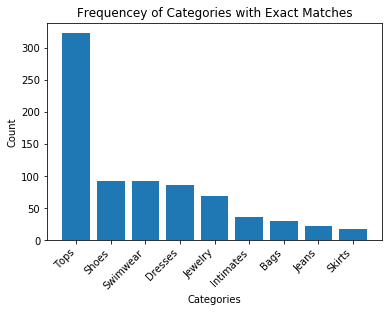

In [81]:
matches = Counter()
for match in data.regex_match:
    matches += Counter(match)
sorted_matches = matches.most_common()

plt.bar([key for key, val in sorted_matches], [val for key, val in sorted_matches])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Frequencey of Categories with Exact Matches')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print()

In [82]:
data.sample(frac=1.0).to_csv('regex.csv', index=False, encoding='utf-8-sig')